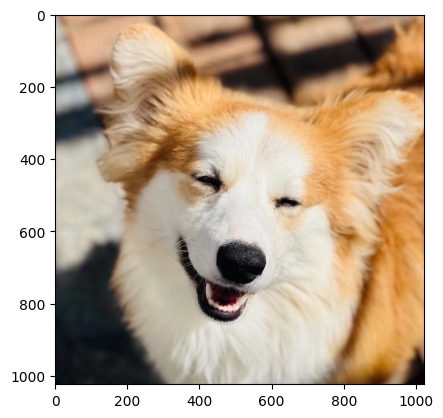

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 打开图像文件
img = plt.imread('dog.bmp')

# 获取图像的大小
height, width, channels = img.shape

# 展示图像
plt.imshow(img)
plt.show()

In [2]:
# 色彩空间转换
img_ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)

In [3]:
# 图像分块
def split_image(img, block_size=8):
    h, w = img.shape[:2]
    bh, bw = h // block_size, w // block_size
    blocks = np.zeros((bh, bw, block_size, block_size, 3))
    for i in range(bh):
        for j in range(bw):
            blocks[i, j] = img[i * block_size:(i + 1) * block_size,
                           j * block_size:(j + 1) * block_size]
    return blocks

# 图像合并
def merge_image(blocks, block_size=8):
    bh, bw = blocks.shape[:2]
    h, w = bh * blocks.shape[2], bw * blocks.shape[3]
    img = np.zeros((h, w, 3))
    for i in range(bh):
        for j in range(bw):
            img[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size] = blocks[i, j]
    return img.astype(np.uint8)

In [4]:
img_blocks = split_image(img_ycbcr)

In [5]:
# 离散余弦变换
def dct(blocks, block_size=8):
    bh, bw = blocks.shape[:2]
    for i in range(bh):
        for j in range(bw):
            blocks[i, j, :, :, 0] = cv2.dct(blocks[i, j, :, :, 0])
    return blocks


def idct(blocks, block_size=8):
    bh, bw = blocks.shape[:2]
    blocks = blocks.astype(np.float64)
    for i in range(bh):
        for j in range(bw):
            blocks[i, j, :, :, 0] = cv2.idct(blocks[i, j, :, :, 0])
    return blocks

In [6]:
img_dct = dct(img_blocks)
# img_dct[0,0,:,:,0]

In [8]:
# 量化表
quantization_table = np.array([[16, 11, 10, 16,  24,  40,  51,  61],
                               [12, 12, 14, 19,  26,  58,  60,  55],
                               [14, 13, 16, 24,  40,  57,  69,  56],
                               [14, 17, 22, 29,  51,  87,  80,  62],
                               [18, 22, 37, 56,  68, 109, 103,  77],
                               [24, 35, 55, 64,  81, 104, 113,  92],
                               [49, 64, 78, 87, 103, 121, 120, 101],
                               [72, 92, 95, 98, 112, 100, 103,  99]])

# 量化
def quantize(blocks, table):
    bh, bw = blocks.shape[:2]
    for i in range(bh):
        for j in range(bw):
            blocks[i, j, :, :, 0] /= table
    return np.round(blocks).astype(np.int64)


def dequantize(blocks, table):
    blocks = blocks.astype(np.int64)
    bh, bw = blocks.shape[:2]
    for i in range(bh):
        for j in range(bw):
            blocks[i, j, :, :, 0] *= table
    return np.round(blocks)

In [9]:
img_quantized = quantize(img_dct,quantization_table)

In [11]:
def bmp2jpeg(img, table, block_size=8):
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)  # 色彩空间转换
    img_blocks = split_image(img_ycbcr)  # 图像分块
    img_dct = dct(img_blocks)  # 离散余弦变换
    img_quantized = quantize(img_dct, table)  # 量化
    return img_quantized

In [12]:
jpeg = bmp2jpeg(img,quantization_table)

In [13]:
def jpeg2bmp(img, table, block_size=8):
    img_dequantized = dequantize(img, table)  # 反量化
    img_idct = idct(img_dequantized)  # 图像合并
    img_merge = merge_image(img_idct)  # 离散余弦反变换
    img_rgb = cv2.cvtColor(img_merge, cv2.COLOR_YCR_CB2RGB)  # 色彩空间转换
    return img_rgb

In [14]:
bmp = jpeg2bmp(jpeg,quantization_table)

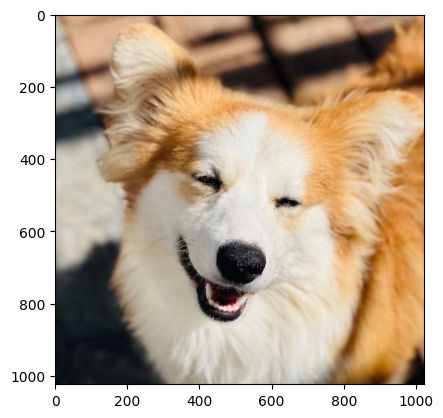

In [15]:
plt.imshow(bmp)

In [17]:
def zigzag_scan(matrix):
    """z字形扫描"""
    h, w = matrix.shape
    result = []
    x, y = 0, 0
    dx, dy = -1, 1
    while x <= h - 1 and y <= w - 1:
        result.append(matrix[x, y])
        if dx > 0 and dy < 0:
            if x == h - 1:
                y += 1
                dx, dy = -1, 1
            elif y == 0:
                x += 1
                dx, dy = -1, 1
            else:
                x += dx
                y += dy

        else:
            if y == w - 1:
                x += 1
                dx, dy = 1, -1
            elif x == 0:
                y += 1
                dx, dy = 1, -1
            else:
                x += dx
                y += dy
    return result

In [18]:
# 示例矩阵
matrix = np.array([[ 1,  2,  3,  4], 
                   [ 5,  6,  7,  8], 
                   [ 9, 10, 11, 12], 
                   [13, 14, 15, 16]])

# Z字形扫描结果
result = zigzag_scan(matrix)
print(result)  # [1, 2, 5, 9, 6, 3, 4, 7, 10, 13, 14, 11, 8, 12, 15, 16]

[1, 2, 5, 9, 6, 3, 4, 7, 10, 13, 14, 11, 8, 12, 15, 16]


In [19]:
def zigzag_inverse(values, shape):
    """z字形扫描反变换"""
    h, w = shape
    result = np.zeros((h, w), dtype=matrix.dtype)
    x, y = 0, 0
    dx, dy = -1, 1
    i = 0
    while x <= h - 1 and y <= w - 1:
        result[x, y] = values[i]
        i += 1
        if dx > 0 and dy < 0:
            if x == h - 1:
                y += 1
                dx, dy = -1, 1
            elif y == 0:
                x += 1
                dx, dy = -1, 1
            else:
                x += dx
                y += dy
        else:
            if y == w - 1:
                x += 1
                dx, dy = 1, -1
            elif x == 0:
                y += 1
                dx, dy = 1, -1
            else:
                x += dx
                y += dy
    return result

In [21]:
# F3隐藏
text = "Hello world!"  # 秘密信息
b_text = text.encode()
secret_data = [bin(c)[2:].zfill(8) for c in b_text]  # 编码为8位二进制数
secret_data = ''.join(secret_data)
secret_data

'010010000110010101101100011011000110111100100000011101110110111101110010011011000110010000100001'

In [22]:
# 嵌入
def f3_embed(img, table, secret_data):
    jpeg_img = bmp2jpeg(img, table)  # 转化为jpeg
    dlen = len(secret_data)
    if dlen > 255:
        raise ValueError('Secret message too large to encode in image')
    embed_data = bin(dlen)[2:].zfill(8) + secret_data  # 将秘密信息的长度加到嵌入信息的前8位
    bh, bw = jpeg_img.shape[:2]
    # F3信息嵌入
    for i in range(bh):
        for j in range(bw):
            pixels = zigzag_scan(jpeg_img[i, j, :, :, 0])
            for k in range(len(pixels)):
                # 每个非0的DCT数据用于隐藏1比特秘密信息，为0的DCT系数不负载秘密信息。
                if pixels[k] != 0:
                    # 当原始值为+1或-1且预嵌入秘密信息为0时，将这个位置归0并视为无效，在下一个DCT系数上重新嵌入。

                    if abs(pixels[k]) == 1 and embed_data[0] == '0':
                        pixels[k] = 0
                    # 如果秘密信息与DCT的LSB相同，便不作改动；如果不同，将DCT系数的绝对值减小1，符号不变。
                    else:
                        if pixels[k] % 2 != int(embed_data[0]):
                            pixels[k] = pixels[k] / abs(pixels[k]) * (abs(pixels[k]) - 1)
                        embed_data = embed_data[1:]
                if len(embed_data) == 0:
                    break
            jpeg_img[i, j, :, :, 0] = zigzag_inverse(pixels, jpeg_img[i, j, :, :, 0].shape)

            if len(embed_data) == 0: break
        if len(embed_data) == 0: break
    return jpeg_img


secret_img = f3_embed(img, quantization_table, secret_data)

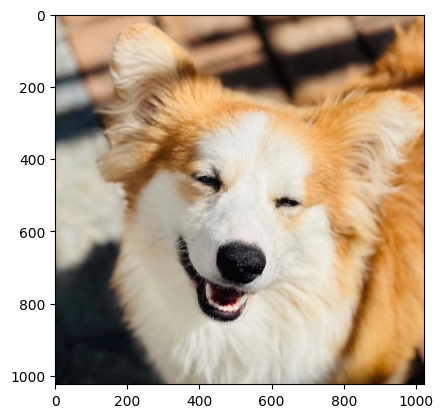

In [23]:
plt.imshow(jpeg2bmp(secret_img, quantization_table))

In [24]:
# 提取
def f3_extract(img):
    bh, bw = img.shape[:2]
    secret_data = ''
    length = 9
    for i in range(bh):
        for j in range(bw):
            pixels = zigzag_scan(img[i, j, :, :, 0])
            for k in range(len(pixels)):
                if pixels[k] != 0:
                    secret_data += str(pixels[k] % 2)
                # 提取出秘密信息的前8位即秘密信息的长度
                if len(secret_data) == 8:
                    length = int(secret_data, base=2) + 8
                if len(secret_data) == length:  break
            if len(secret_data) == length:  break
        if len(secret_data) == length:  break
    return secret_data[8:]

In [25]:
secret_data = f3_extract(secret_img)
secret_data
#  010010000110010101101100011011000110111100100000011101110110111101110010011011000110010000100001

'010010000110010101101100011011000110111100100000011101110110111101110010011011000110010000100001'

In [26]:
secret_text = bytes(
    [int(secret_data[i:i + 8], base=2) for i in range(0, len(secret_data), 8)]).decode()  # 将二进制秘密信息转换为文本

In [27]:
secret_text

'Hello world!'

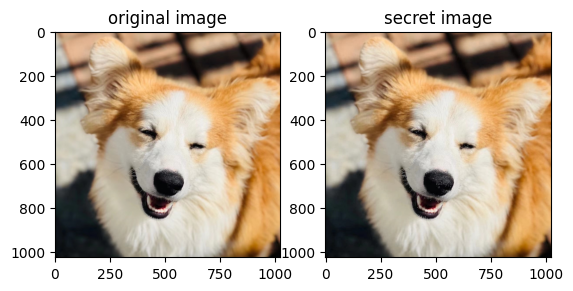

In [31]:
plt.subplot(1, 2, 1)
plt.title("original image")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title("secret image")
plt.imshow(jpeg2bmp(secret_img, quantization_table))